(11161, 46)
Epoch 1/11, Loss: 0.6302225332174982
Epoch 2/11, Loss: 0.5425895399280957
Epoch 3/11, Loss: 0.4911941966840199
Epoch 4/11, Loss: 0.4707895040512085
Epoch 5/11, Loss: 0.46120249884469167
Epoch 6/11, Loss: 0.4462484998362405
Epoch 7/11, Loss: 0.4379271854247366
Epoch 8/11, Loss: 0.4334675045950072
Epoch 9/11, Loss: 0.7518282462443624
Epoch 10/11, Loss: 0.45087972304650714
Epoch 11/11, Loss: 0.43341356941631864
Test accuracy: 0.8137035378414689
Total: 2233


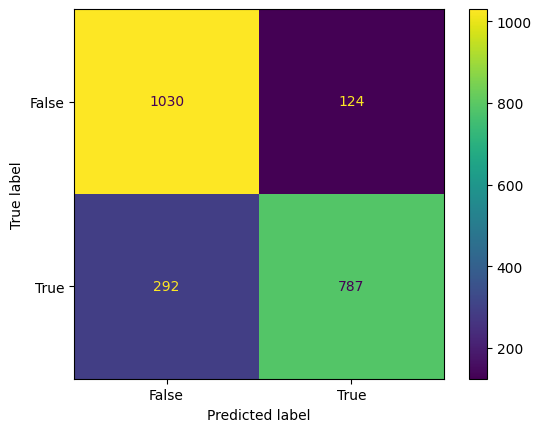

Precision: 0.8638858397365532
Recall: 0.7293790546802595
F1 Score: 0.7909547738693468
Training set
Test accuracy: 0.8066756272401434
Total: 8928


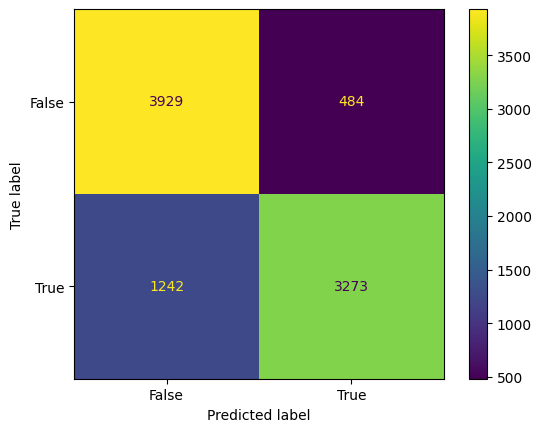

Precision: 0.8711738088900719
Recall: 0.7249169435215946
F1 Score: 0.7913442940038685


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

DATA_STORED = "website_data_more.npy"
TRAIN = '2train.npy'
TEST = '2test.npy'

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from src.NeuralNetwork import NeuralNetwork

data_array = np.load(DATA_STORED)
print(data_array.shape)

# Assuming numpy array has the shape (num_datapoints, 21)
# The last column is the label, and the first 20 columns are the features
features = data_array[:,:-1]
labels = data_array[:,-1]

# Convert to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)

# Create DataLoader for training and testing data
batch_size = 64
train_dataset = TensorDataset(features_train, labels_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(features_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hyperparameters
input_size = 45
hidden_size = 40
output_size = 1
num_hidden_layers = 10
learning_rate = 0.002
num_epochs = 11

# Instantiate the model, move it to the GPU
model = NeuralNetwork(input_size, hidden_size, output_size, num_hidden_layers).to(device)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# trainig
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs.view(-1), batch_labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# Test set eval
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0

    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        total += batch_labels.size(0)
        correct += (predicted.view(-1) == batch_labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    #print("test dataset shape ", str(test_dataset.shape))
    accuracy = correct / total
    print("Test accuracy:", accuracy)
    print("Total:", total)
    all_predictions = np.array(all_predictions).flatten()
    all_labels = np.array(all_labels)

    # Compute metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    confusion_matrixx = confusion_matrix(all_labels, all_predictions) 
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrixx, display_labels = [False, True]) 
    cm_display.plot()
    plt.show() 

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

all_predictions = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    print("Training set")

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        total += batch_labels.size(0)
        correct += (predicted.view(-1) == batch_labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    #print("test dataset shape ", str(test_dataset.shape))
    accuracy = correct / total
    print("Test accuracy:", accuracy)
    print("Total:", total)
    all_predictions = np.array(all_predictions).flatten()
    all_labels = np.array(all_labels)

    # Compute metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    confusion_matrixx = confusion_matrix(all_labels, all_predictions) 
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrixx, display_labels = [False, True]) 
    cm_display.plot()
    plt.show() 

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)



# Load the saved model
# model = NeuralNetwork(input_size, hidden_size, output_size, num_hidden_layers).to(device)
# model.load_state_dict(torch.load(model_path))
# model.eval()


In [17]:
constant_predictions = np.ones(len(train_loader.dataset))
cpz = np.zeros(len(train_loader.dataset))

true_labels = [batch_labels.numpy() for _, batch_labels in train_loader]
true_labels = np.concatenate(true_labels)

# Compute the F1 score, precision, and recall for constant prediction of 1
f1 = f1_score(true_labels, constant_predictions)
f1z = f1_score(true_labels, cpz)
precision = precision_score(true_labels, constant_predictions)
recall = recall_score(true_labels, constant_predictions)

print("F1 Score ones (base f1 score):", f1)
print("Precision:", precision)
print("Recall:", recall)

F1 Score ones: 0.6717250613702298
Precision: 0.5057123655913979
Recall: 1.0


In [6]:
save_input = input("Save file? (y/n)")
while save_input != "y" and save_input != "n":
    save_input = input("Save file? (y/n)")
if save_input == "y":
    print("File will be saved under 'trained_weights' folder")
    model_path = input("Filename to save (****.pth) ")
    if model_path == "":
        model_path = '{}_{}_{}_{}.pth'.format(str(learning_rate),str(num_epochs),str(num_hidden_layers),str(hidden_size))
    else:
        model_path = '{}_{}_{}_{}_{}.pth'.format(model_path,str(learning_rate),str(num_epochs),str(num_hidden_layers),str(hidden_size))
    save_path = '{}/{}'.format("trained_weights/neural", model_path)
    torch.save(model.state_dict(), save_path)
    print("Model saved successfully at:", save_path)

File will be saved under 'trained_weights' folder
Model saved successfully at: trained_weights/neural/scn_0.002_11_10_40.pth
